In [1]:
"""
Gillespie SSA implemented for model in Figure 1 
condition: wild type
genomic location: bivalent genes (bivalent)
input: average profile of p300/UTX and suz12 at bivalent
output: corresponding average profile of H3K27me1/me2/me3/ac
"""
import multiprocessing

# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba
import  math

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [2]:
"""
used numba compiler for better speed
"""

@numba.jit(nopython=True)
def sum_numba(ar):
    return ar.sum()

In [3]:
@numba.jit(nopython=True)
def propensity(param1, param2, param3, param4,  population):
    """
    Returns an array of propensities given a set of parameters
    and an array of population.
    """
    # Unpack parameters, the description is in cell 8
    kac, eac, ta, ya, gamma = param1
    km01, km12, km23, emb01, emb12, emb23  = param2
    kdm01, kdm12, kdm23 = param3
    tm1, tm2, tm3 = param4 
    
    # Unpack population state
    St = population.copy(); N = len(St);  
    
    # Average suz12 at bivalent domain fitted to gaussian 
    SUZ12 = np.zeros((N,),dtype=np.float64);sum_SUZ12 = np.zeros((N,),dtype=np.float64);
    a =  0.0782   ; b = 3.7502   ; c = 10.6075     ; d = 0.0444   
    for x in range(-100,100):
        y = x+100;
        SUZ12[y] =  SUZ12[y] = a*np.exp(-((x-b)/c)**2) + d
        
    for i in range(0,N):
        for j in range(0,N):
            if j !=i:
                sum_SUZ12[i] = sum_SUZ12[i] + SUZ12[j]*pow(abs(j-i), -gamma);
    
    # Average p300 at bivalent domain fitted to gaussian 
    p300 = np.zeros((N,),dtype=np.float64); sum_p300 = np.zeros((N,),dtype=np.float64);
    a = 0.0979   ; b =  0.3626  ; c = 11.7575 ; d =  0.1057                   
    for x in range(-100,100):
        y = x+100;
        p300[y] =  p300[y] = a*np.exp(-((x-b)/c)**2) + d

        
    for i in range(0,N):
        for j in range(0,N):
            if j !=i:
                sum_p300[i] = sum_p300[i] + (p300[j])*pow(abs(j-i), -gamma);

    # Average UTX at bivalent fitted to gaussian         
    UTX = np.zeros((N,),dtype=np.float64); sum_UTX =  np.zeros((N,),dtype=np.float64);
    a = 0.0422   ; b =  0.5647 ; c = 4.7337  ; d =   0.1329                
    for x in range(-100,100):
        y = x+100;
        UTX[y] = UTX[y] + a*np.exp(-((x-b)/c)**2) + d
        
    for i in range(0,N):
        for j in range(0,N):
            if j !=i:
                sum_UTX[i] = sum_UTX[i] +  (UTX[j])*pow(abs(j-i),-gamma);  
                
    for i in range(0,N):
        for j in range(0,N):
            if j !=i:
                sum_UTX[i] = sum_UTX[i] +  (UTX[j])*pow(abs(j-i),-gamma);   
                
    # spreading term   
    Ac = np.zeros((N,),dtype=np.float64); Mc1_BR = np.zeros((N,),dtype=np.float64);
    Mc2_BR = np.zeros((N,),dtype=np.float64); Mc3_BR = np.zeros((N,),dtype=np.float64);
    for i in range(0,N):
        for j in range(0,N):
            if j !=i:
                Mc1_BR[i] = Mc1_BR[i] + SUZ12[j]*pow(abs(j-i), -gamma)*(St[j] == -1);
                Mc2_BR[i] = Mc2_BR[i] + SUZ12[j]*pow(abs(j-i), -gamma)*(St[j] == -2);
                Mc3_BR[i] = Mc3_BR[i] + SUZ12[j]*pow(abs(j-i), -gamma)*(St[j] == -3);
     
    # Assigning propnsities 
    Prn = np.zeros((12,N));
    for i in range(0,N):
        Prn[0,i] = (St[i] == 0)*(kac*p300[i] + eac*sum_p300[i]/N);
        Prn[4,i] = (St[i] == 1)*(ta);
        Prn[8,i] = (St[i] == 1)*(ya);

    for i in range(0,N):
        Prn[1,i] = (St[i] == 0)*(km01*SUZ12[i]  +  emb01*Mc3_BR[i]/N);
        Prn[2,i] = (St[i] == -1)*(km12*SUZ12[i] +  emb12*Mc3_BR[i]/N);
        Prn[3,i] = (St[i] == -2)*(km23*SUZ12[i] +  emb23*Mc3_BR[i]/N);
        Prn[5,i] = (St[i] == -1)*(tm1);
        Prn[6,i] = (St[i] == -2)*(tm2);
        Prn[7,i] = (St[i] == -3)*(tm3);
        Prn[9,i] = (St[i] == -1)*(kdm01*UTX[i] );
        Prn[10,i] = (St[i] == -2)*(kdm12*UTX[i] );
        Prn[11,i] = (St[i] == -3)*(kdm23*UTX[i] );
             
    return Prn

In [4]:
@numba.jit(nopython=True)
def sample_discrete(probs, probs_sum):
    """
    Randomly sample the histone site (nuc) and reaction( rxn) 
    given propensities and its sum
    """
    q = np.random.rand() * probs_sum
    
    p_sum = 0.0
    
    for nuc in range(0,probs.shape[1]):
        for rxn in range(0,probs.shape[0]):
            p_sum += probs[rxn,nuc]
            if p_sum > q:
                break
        if p_sum > q:
                break              
    
    return rxn,nuc

In [5]:
@numba.jit(nopython=True)
def gillespie_draw(param1, param2, param3, param4, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute rxn propensities
    props_rxn = propensity(param1, param2, param3, param4, population)
    
    # Sum of propensities
    props_sum = sum_numba(props_rxn)
    
    # Compute time
    if props_sum != 0:
        # Gillespie time interval
        time = np.random.exponential(1 / props_sum)
        # Draw reaction anf histone given the propensities
        rxn, nuc = sample_discrete(props_rxn, props_sum)
        
    return rxn, nuc, time


# implement replication event
@numba.jit(nopython=True)
def gillespie_replication_event(population):
    
    pops = population
    probs_rand_rp = np.random.random(len(pops))
    # 50% chance a modified histone becomes unmodified
    for i in range(0,len(pops)):
        if pops[i] != 0 and probs_rand_rp[i] < 0.5:
            pops[i]=0
                
    return pops

# implement full ssa
@numba.jit(nopython=True)
def gillespie_ssa(param1, param2, param3, param4, population_0, time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from propensities over time.
    
    Parameters
    ----------
    params : The set of parameters to be passed to propensity function.
    population_0 : Array of histone modification 
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : array of (n_simulations, 5*N+1)
            In each simulation, return sum(dt*me3/2/1/ac) and sum (dt) 
            for calculating average over time
    
    """
    ssa_out = np.zeros(5*len(population_0)+1, dtype = np.float64)
    # Initialize
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    cycle = 1; 
    me3_dt = np.zeros(len(population_0));
    me2_dt = np.zeros(len(population_0)); 
    me1_dt = np.zeros(len(population_0));
    u_dt = np.zeros(len(population_0));
    ac_dt = np.zeros(len(population_0));
    delta_t = 0
    
    while t < ncyc*tau*3600:     
        # drwan which rxn at which nucleosome at what time will ocuur
        rxn, nuc, dt = gillespie_draw(param1, param2, param3, param4, population)
        population_previous = population.copy()
        # update the population of chose site    
        population[nuc] = (rxn == 0)*(1) + (rxn == 1)*(-1) + (rxn == 2)*(-2) +  (rxn == 3)*(-3) \
                              + (rxn == 4)*(0) + (rxn == 5)*(0) + (rxn == 6)*(0) + (rxn == 7)*(0) \
                               + (rxn == 8)*(0) + (rxn == 9)*(0) + (rxn == 10)*(-1) + (rxn == 11)*(-2)                
        # Increment time
        t += dt
        # see if its time to replicate
        if t > cycle*tau*3600:
            popr = gillespie_replication_event(population)
            population = popr 
            cycle = cycle + 1;          
         # update the population*dt and time of chain   
        if t > cycle*(tau)*3600-(tau-0)*3600:
            delta_t = delta_t + dt
            for x in range(0,len(population_0)):
                me3_dt[x] = me3_dt[x] + (population[x] == -3)*dt
                me2_dt[x] = me2_dt[x] + (population[x] == -2)*dt
                me1_dt[x] = me1_dt[x] + (population[x] == -1)*dt
                u_dt[x] = u_dt[x] + (population[x] == 0)*dt
                ac_dt[x] = ac_dt[x] + (population[x] == 1)*dt
    # store the population*dt and time interval   
    ssa_out[0:len(population_0)] = me3_dt[:]
    ssa_out[len(population_0):2*len(population_0)] = me2_dt[:]
    ssa_out[2*len(population_0):3*len(population_0)] = me1_dt[:]
    ssa_out[3*len(population_0):4*len(population_0)] = u_dt[:]
    ssa_out[4*len(population_0):5*len(population_0)] = ac_dt[:]
    ssa_out[5*len(population_0)] = delta_t                    
    return ssa_out

In [6]:
# Parallelize number of simulation into threads

def gillespie_fn(args):
    return gillespie_ssa(*args)
    
def gillespie_parallel(fn, param1, param2, param3, param4, population_0, time_points,
                       n_simulations, n_threads):
    """
    Convenience function to do parallel Gillespie simulations for simple
    gene expression.
    """
    input_args = (param1, param2, param3, param4, population_0, time_points)

    with multiprocessing.Pool(n_threads) as p:
        ssa_output = p.map(fn, [input_args]*n_simulations)
        
    return np.array(ssa_output)

In [7]:
# Average profiles of experimental H3K27me3/me2/me1/ac at bivalent

from numpy import genfromtxt
me3_data_file = genfromtxt('me3-B-200.csv', delimiter=',')
me2_data_file = genfromtxt('me2-B-200.csv', delimiter=',')
me1_data_file = genfromtxt('me1-B-200.csv', delimiter=',')
ac_data_file = genfromtxt('ac-B.csv', delimiter=',')
ac_data = ac_data_file[1:401]
me3_data = me3_data_file[1:201]
me2_data = me2_data_file[1:201]
me1_data = me1_data_file[1:201]

In [8]:
# Assigning parameters in here

n_simulations = 32
N = 200; # number of histones
ncyc = 25 # time (number of life cycles simulated )
tau = 13.5; # cell cycle (hr)


t = 0.03/3600; # turnover rate (per sec) 
ta = t; tm1 = t; tm2 = t; tm3 = t # turnover of ac/me1/me2/me3
gamma=1; # power law coefficient


da = 0.6/3600 # deacetylation rate (per sec) 
kac =2.8720e-04; # acetylation rate fixed after fitting for dKO case (per sec) 
eac = 0; 

km3 = 0.25*(1e-3); # fitted nucleation rate (per sec) after convergence  
emb3=170*km3; # fitted spreading rate (per sec) after convergenece R = 170/N 
kdm3 =1*1.6*km3;  kdm2 = 1*kdm3; kdm1 =1*kdm3; # fitted demethylation rate (per sec) after convergence 

rm2 = 3.0; rm1 = 3.0 # fixed ratios r13 and r23
km1 = rm1*km3; km2 = rm2*km3; 
emb1 = rm1*emb3; emb2 = rm2*emb3;


param1 = np.array([kac, eac, ta, da, gamma]) 
#  ka, ea, ta, da, gamma = param1
param2 = np.array([km1, km2, km3, emb1, emb2, emb3]) 
#   km01, km12, km23,  emb01, emb12, emb23 
param3 = np.array([kdm1, kdm2, kdm3]) 
#  kdm1, kdm2, kdm3 = param3
param4 = np.array([tm1, tm2, tm3]) 
# tm1, tm2, tm3 = param4 


population_0 = np.full((N,), 0, dtype=np.int8)
time_points = np.linspace(0,ncyc*tau*3600, ncyc*tau*36 + 1)

# Initialize output arrays
ssa_sim_out = np.empty((n_simulations, 5*N+1))

ssa_sim_out = gillespie_parallel(gillespie_fn, param1, param2, param3, param4, population_0,
                                 time_points, n_simulations, 16)

me3dt_output = ssa_sim_out[:,:N]; me2dt_output = ssa_sim_out[:,N:2*N]; me1dt_output = ssa_sim_out[:,2*N:3*N]
udt_output = ssa_sim_out[:,3*N:4*N]; acdt_output = ssa_sim_out[:,4*N:5*N]; delta_t = ssa_sim_out[:,5*N]


s_me3= me3dt_output; s_me2= me2dt_output; s_me1= me1dt_output; s_u= udt_output; s_ac= acdt_output
tot_t= delta_t

prob_me3 = np.empty((n_simulations,N),dtype = np.float64)
prob_me2 = np.empty((n_simulations,N),dtype = np.float64)
prob_me1 = np.empty((n_simulations,N),dtype = np.float64)
prob_u = np.empty((n_simulations,N),dtype = np.float64)
prob_ac = np.empty((n_simulations,N),dtype = np.float64)

# calc time averages
for i in range(0, n_simulations):
    prob_me3[i,:] = s_me3[i,:]/tot_t[i]
    prob_me2[i,:] = s_me2[i,:]/tot_t[i]
    prob_me1[i,:] = s_me1[i,:]/tot_t[i]
    prob_u[i,:] = s_u[i,:]/tot_t[i]
    prob_ac[i,:] = s_ac[i,:]/tot_t[i]
    
mean_prob_me3 = np.mean(prob_me3, axis = 0)
std_prob_me3 = np.std(prob_me3, axis = 0)
mean_prob_me2 = np.mean(prob_me2, axis = 0)
std_prob_me2 = np.std(prob_me2, axis = 0)
mean_prob_me1 = np.mean(prob_me1, axis = 0)
std_prob_me1 = np.std(prob_me1, axis = 0)
mean_prob_u = np.mean(prob_u, axis = 0)
std_prob_u = np.std(prob_u, axis = 0)
mean_prob_ac = np.mean(prob_ac, axis = 0)
std_prob_ac = np.std(prob_ac, axis = 0)


/home/nemark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Text(0, 0.5, 'data')

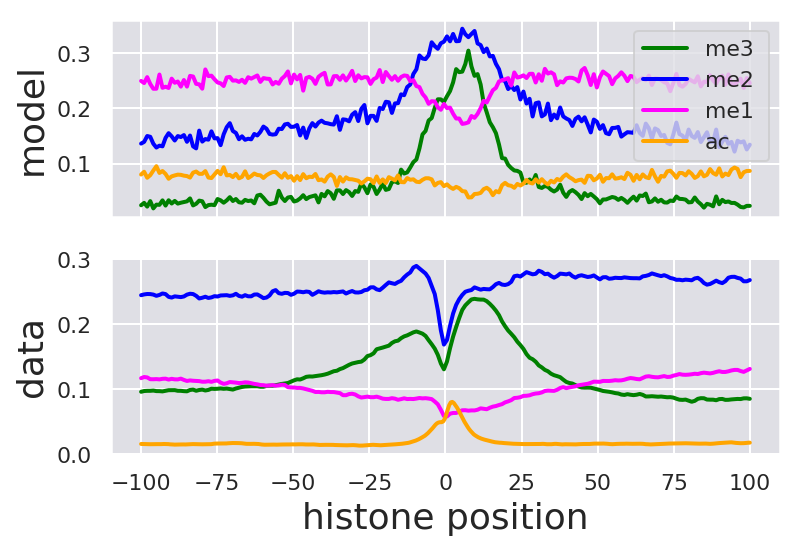

In [9]:
# Simulated and experimental profiles

x_axis = np.linspace(-100,100,200)
x400 = np.linspace(-100,100,400)
ax1 = plt.subplot(211)
plt.plot(x_axis, mean_prob_me3, color='green', label = 'me3 ')
plt.plot(x_axis, mean_prob_me2, color='blue', label = 'me2 ')
plt.plot(x_axis, mean_prob_me1, color='magenta', label = 'me1 ')
plt.plot(x_axis, mean_prob_ac, color='orange', label = 'ac')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('model')
plt.legend()

# share x only
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(x_axis, me3_data, color='green',  label = 'data')
plt.plot(x_axis, me2_data, color='blue',  label = 'data')
plt.plot(x_axis, me1_data, color='magenta', label = 'data')
plt.plot(x400, ac_data, color='orange', label = 'data')
plt.xlabel('histone position')
plt.ylabel('data')

In [10]:
# save session
import dill
dill.dump_session('Profile_WT_B200')

In [11]:
# load session
import dill
dill.load_session('Profile_WT_B200')

In [12]:
#save output files
np.savetxt("WT_B_sim_me3.csv", mean_prob_me3, delimiter=",")
np.savetxt("WT_B_sim_me2.csv", mean_prob_me2, delimiter=",")
np.savetxt("WT_B_sim_me1.csv", mean_prob_me1, delimiter=",")
np.savetxt("WT_B_sim_ac.csv", mean_prob_ac, delimiter=",")